<a href="https://colab.research.google.com/github/harukamasatsugu/Geometric-Brownian-motion/blob/main/%E5%B9%BE%E4%BD%95%E3%83%96%E3%83%A9%E3%82%A6%E3%83%B3%E9%81%8B%E5%8B%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
uploaded = files.upload()

Saving nikkei_stock_average_daily_jp.csv to nikkei_stock_average_daily_jp.csv


In [9]:
df = pd.read_csv("nikkei_stock_average_daily_jp.csv", encoding="cp932")
print(df.columns)
df.head()

Index(['データ日付', '終値', '始値', '高値', '安値'], dtype='object')


,データ日付,終値,始値,高値,安値
0,2022/01/04,29301.79,29098.41,29323.79,28954.56
1,2022/01/05,29332.16,29288.80,29388.16,29204.45
2,2022/01/06,28487.87,29136.75,29158.95,28487.87
3,2022/01/07,28478.56,28711.53,28813.09,28293.70
4,2022/01/11,28222.48,28380.90,28473.47,28089.49


期待成長率(/日): 0.00044, ボラティリティ(/日): 0.01223


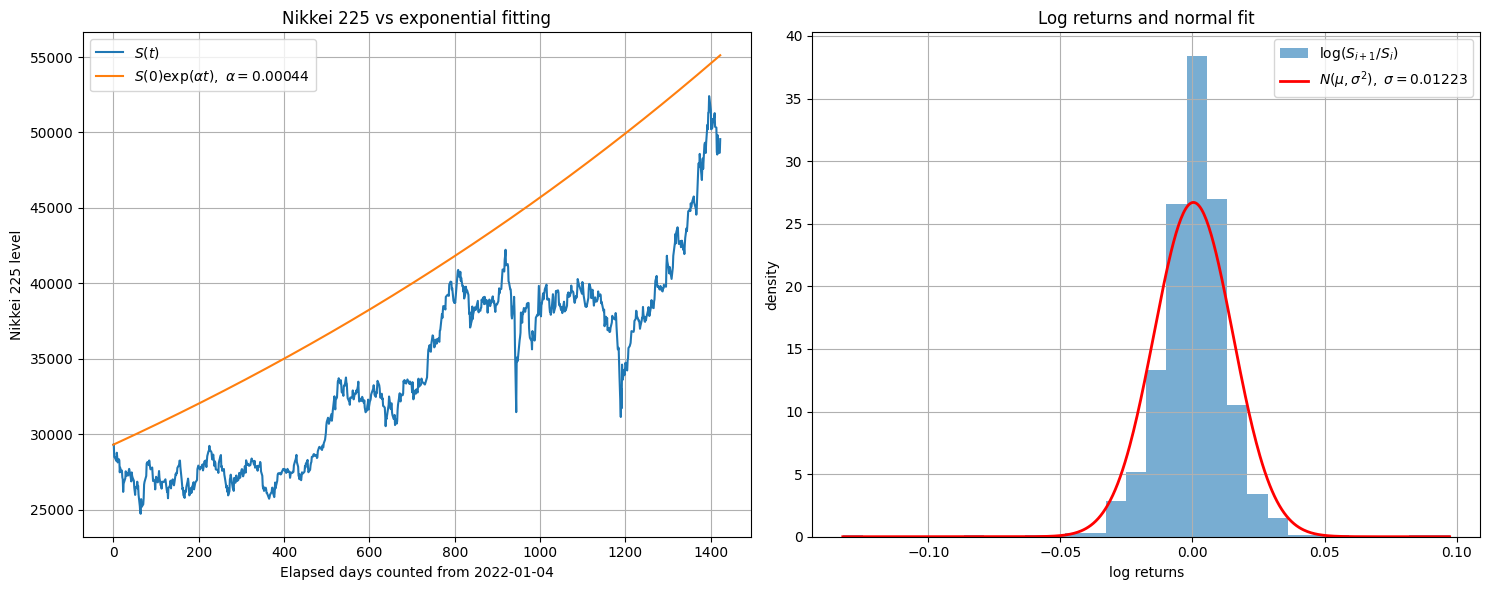

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

# 日経平均株価シートのロード
df = pd.read_csv("nikkei_stock_average_daily_jp.csv", encoding="cp932")

# 1) データ日付を一旦 Datetime に変換（注意書き行は NaT になる）
tmp_date = pd.to_datetime(df['データ日付'], format="%Y/%m/%d", errors="coerce")

# 2) 日付として解釈できる行だけ残す
df = df[tmp_date.notna()].copy()
df['Date'] = tmp_date[tmp_date.notna()]

# 3) 終値を数値として使う（列名は「終値」）
df['終値'] = pd.to_numeric(df['終値'], errors='coerce')
df = df.dropna(subset=['終値'])

# 経過日数
start_date = df['Date'].iloc[0]
df['ElapsedDays'] = (df['Date'] - start_date).dt.days

elapsed_days = df['ElapsedDays'].to_numpy()
end_values = df['終値'].to_numpy()

# 対数リターンを計算
log_returns = np.diff(np.log(end_values))
delta_t = np.diff(elapsed_days)  # 通常は全部 1 日
n = len(delta_t)

# パラメータの最尤推定（1日あたり）
mu_hat = np.sum(log_returns) / np.sum(delta_t)
sigma_hat = np.sqrt(np.sum((log_returns - mu_hat * delta_t)**2 / delta_t) / n)
alpha_hat = mu_hat + 0.5 * sigma_hat**2

print(f"期待成長率(/日): {alpha_hat:.5f}, ボラティリティ(/日): {sigma_hat:.5f}")

# プロット
fig = plt.figure(figsize=(15, 6))

# ax1: 日経平均株価と指数関数フィット
ax1 = fig.add_subplot(121)
ax1.plot(elapsed_days, end_values, label=r'$S(t)$')
ax1.plot(
    elapsed_days,
    end_values[0] * np.exp(alpha_hat * elapsed_days),
    label=rf'$S(0)\exp(\alpha t),\ \alpha={alpha_hat:.5f}$'
)
ax1.set_title("Nikkei 225 vs exponential fitting")
ax1.set_xlabel(f"Elapsed days counted from {start_date.date()}")
ax1.set_ylabel("Nikkei 225 level")
ax1.legend()
ax1.grid(True)

# ax2: log return ヒストグラムと正規分布フィット
ax2 = fig.add_subplot(122)
count, bins, ignored = ax2.hist(
    log_returns,
    bins=30,
    density=True,
    alpha=0.6,
    label=r'$\log(S_{i+1}/S_i)$'
)

x = np.linspace(min(log_returns), max(log_returns), 500)
# delta_t の平均を使って 1日リターンの分布を近似
pdf = stats.norm.pdf(x, loc=mu_hat, scale=sigma_hat * np.sqrt(delta_t.mean()))
ax2.plot(x, pdf, 'r-', lw=2, label=rf'$N(\mu,\sigma^2),\ \sigma={sigma_hat:.5f}$')

ax2.set_title("Log returns and normal fit")
ax2.set_xlabel("log returns")
ax2.set_ylabel("density")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()
